In [1]:
import os
os.environ['http_proxy'] = '127.0.0.1:7890'
os.environ['https_proxy'] = '127.0.0.1:7890'

In [2]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import difflib
import sys
import glob
import requests

from tqdm.auto import tqdm
from pprint import pprint


import plotnine
from plotnine import *

from dfply import *

In [3]:
# authenticate earthengine api
ee.Initialize()

In [4]:
from Modules.Modules import filter_exclude, get_img_df, compute_mean_ci
from Modules.Parallize_df import parallelize_dataframe

# might need reload modules as the code progrocessing
%load_ext autoreload
%autoreload 2

In [5]:
# import GAEZ data from ee_asset
GAEZ_list = ! earthengine ls users/wangjinzhulala/Paper_3/03_GAEZ

# get the admin shp
NCP_provinces = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")

# get the GAEZ pixel size
GAEZ_pix_scale = ee.Image("users/wangjinzhulala/Paper_3/03_GAEZ/GAEZ_2_Moisture_Annual_P_PET_1981_2010_Historical").projection().nominalScale().getInfo()

In [6]:
# pair Chinese city names with english spelling
city_cn_en = dict(zip(['北京市','天津市', '河北省','江苏省', '安徽省', '河南省', '山东省'],
             ['Beijing','Tianjin', 'Hebei','Jiangsu', 'Anhui', 'Henan', 'Shandong']))

### Compute the difference between GAEZ and GYGA

#### import yearbook/GYGA data

In [7]:
# read data
crop_yield_history_1975_2020 = pd.read_csv('./result_csv/crop_yield_history_1975_2020.csv')
GYGA_weighted_by_area_ratio = pd.read_csv('./result_csv/GYGA_weighted_by_area_ratio.csv')

#### convert GAEZ_img (kg DW/ha) to GAEZ_img (g/ha)

In [8]:
# get the historical_attainable_yield
GAEZ_attainable_raw_kg_DW_ha = pd.read_pickle('../Step_2_Sort_GAEZ_layers/result_csv/attainable_yield_interpolated.pkl')

# convert attainable yield (kg DW/ha) to practical yield (t/ha)
GAEZ_attainable_raw_t_ha_dfs = []
for idx,row in GAEZ_attainable_raw_kg_DW_ha.iterrows():

  crop = row['crop']
  water = row['water']
  year = row['year']
  rcp = row['rcp']
  img_yield = row['image']
  img_sd =  ee.Image(0) if rcp=='Historical' else row['img_future_sd'] 
  
  # convert attainable yield (kg DW/ha) to practical yield (t/ha)
  stats_dict = {}
  ratio = 0.87/1000 if crop == "Maize" else 0.875/1000
  stats_dict['image'] = [img_yield.multiply(ratio)]
  stats_dict['img_future_sd'] = [img_sd.multiply(ratio)]
  stats_df = pd.DataFrame(stats_dict)

  stats_df['crop'] = crop
  stats_df['water'] = water
  stats_df['year'] = year
  stats_df['rcp'] = rcp

  GAEZ_attainable_raw_t_ha_dfs.append(stats_df)

# concat all dfs to a single df
GAEZ_attainable_raw_t_ha_df = pd.concat(GAEZ_attainable_raw_t_ha_dfs).reset_index(drop=True)

#### Compute the mean GAEZ attainbale (t/h) in each province

In [9]:
def compute_area_weighted_mean(df,in_img_name='image'):

  ##################### Multiply each crop_water with its area_ratio #############
  # read the harvested area ratio so we can compute the weigted mean attainable yield
  area_ratio = pd.read_pickle('./result_csv/harvested_area_ratio.pkl')
  df = df.merge(area_ratio,on=['crop','water'])

  # compute the area_weighted actual yield
  df['val_area_weighted'] = df.apply(lambda x:x[in_img_name].multiply(x['area_ratio']),1)
  df['sd_area_weighted'] = df.apply(lambda x:ee.Image(x['img_future_sd']).multiply(x['area_ratio']),1)

  ##################### Sum the area_weighted yield #############
  stats_dict = {}
  for idx,df in df.groupby(['crop','year','rcp']):

    img_val = ee.ImageCollection(df['val_area_weighted'].tolist()).sum()
    img_sd = ee.ImageCollection(df['sd_area_weighted'].tolist()).sum()

    stats_dict[idx] = {'img_val':img_val,"img_sd":img_sd}

  ##################### make the stats a sensibel df #############
  out_df = pd.DataFrame(stats_dict).T.reset_index()
  out_df = out_df.rename(columns={'level_0':'crop','level_1':'year','level_2':'rcp'})

  return out_df

In [10]:
# function to get attianable yield for each province
def compute_yield_each_province(in_df):

  # hack to show progress bar
  print(' ',end='',flush=True)

  df_list = []

  # compute the attainable yield in each provinces
  for idx,row in tqdm(in_df.iterrows(),total=len(in_df)):
    crop = row['crop']
    year = row['year']
    rcp = row['rcp']

    img_val = row['img_val'].toFloat()
    img_ds = ee.Image(0).toFloat() if year<=2010 else row['img_sd'].toFloat()
    img = ee.Image([img_val,img_ds]).rename(['val','sd'])

    # compute stats from GEE
    stats = img.reduceRegions(collection=NCP_provinces,reducer='mean',scale=GAEZ_pix_scale).getInfo()

    # get data
    stats_df = pd.DataFrame({i['properties']['EN_Name']:[i['properties']['val']] for i in stats['features']}).T
    stats_df['sd'] = [i['properties']['sd'] for i in stats['features']] 

    # append infomation
    stats_df = stats_df.reset_index()
    stats_df.columns=['Province','Mean Production','sd']
    stats_df['crop'] = crop
    stats_df['year'] = year
    stats_df['rcp'] = rcp

    stats_df['top'] = stats_df['Mean Production'] + stats_df['sd']
    stats_df['bot'] = stats_df['Mean Production'] - stats_df['sd']
    
    # store df                        
    df_list.append(stats_df)

  # concat dfs
  out_df = pd.concat(df_list,ignore_index=True)
  
  return out_df

In [11]:
# 1) first get area_weighted mean attainable yield (t/ha)
GAEZ_attainable_area_weighted_mean = compute_area_weighted_mean(GAEZ_attainable_raw_t_ha_df)

# 2) then get mean attainable yield (t/ha) in each province
GAEZ_attainable_area_weighted_mean_each_province = parallelize_dataframe(GAEZ_attainable_area_weighted_mean,compute_yield_each_province,40)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

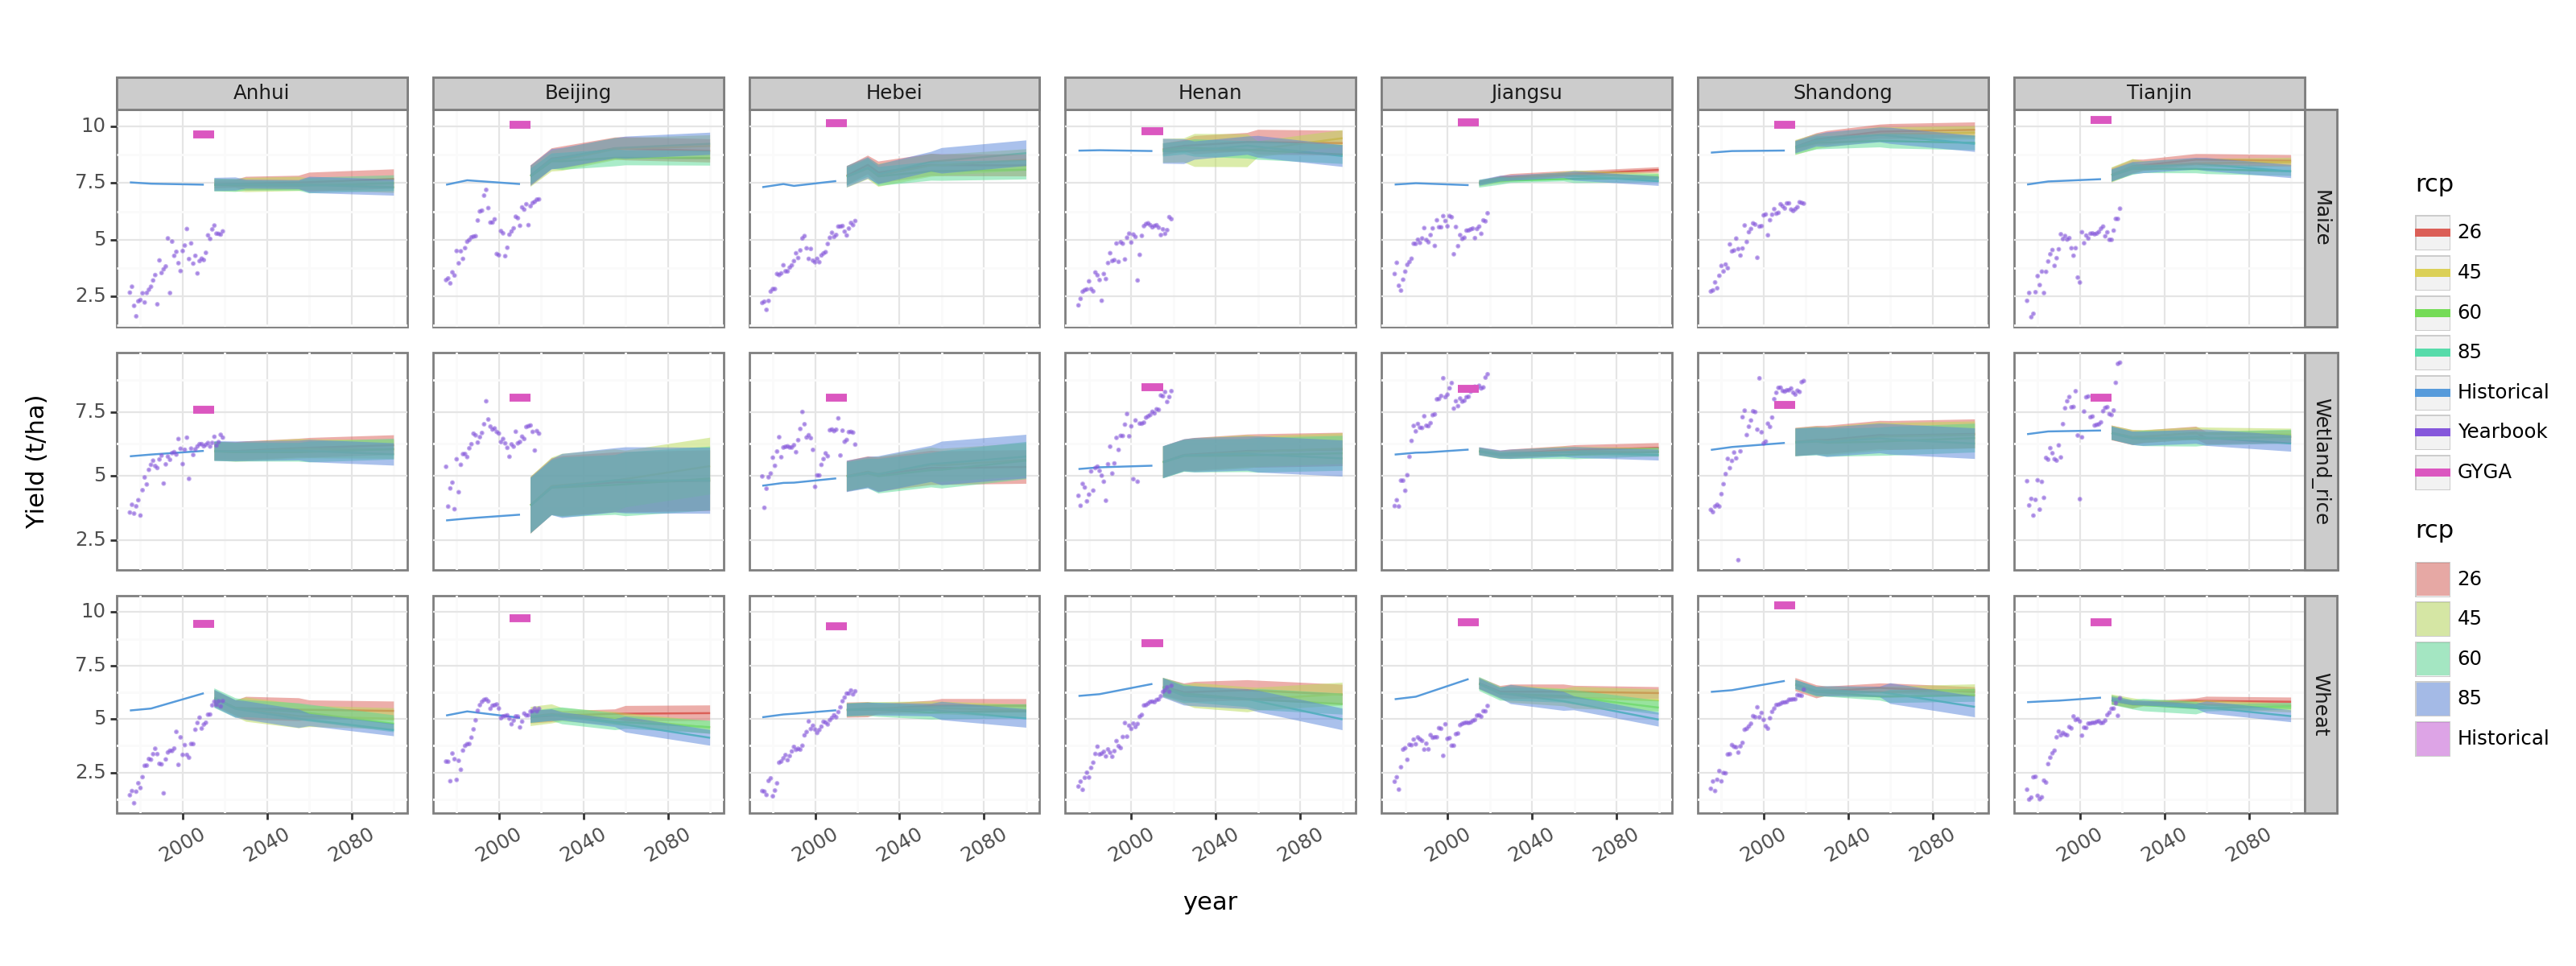

<Figure Size: (1600 x 600)>

In [12]:
# plot to observe the difference between GYGA and GAEZ data
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
 geom_line(GAEZ_attainable_area_weighted_mean_each_province, aes('year','Mean Production',color='rcp')) +
 geom_ribbon(GAEZ_attainable_area_weighted_mean_each_province, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.5) +
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production',color='rcp'),alpha=0.5,size=0.2) +
 geom_line(GYGA_weighted_by_area_ratio, aes('year','Mean Production',color='rcp'),size=2) +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)

#### Compute the difference between GAEZ and GYGA 
- Difference moethod 1: **Subtract** the mean GYGA with the mean GAEZ attainable yield
- Difference moethod 2: **Divide** the mean GYGA with the mean GAEZ attainable yield

In [13]:
# filter the GYGA_2010 and GAEZ_2010
GYGA_weighted_by_area_ratio_2010 = GYGA_weighted_by_area_ratio[GYGA_weighted_by_area_ratio['year']==2005].drop('year',1)
GAEZ_attainable_t_ha_each_province_2010 = GAEZ_attainable_area_weighted_mean_each_province[GAEZ_attainable_area_weighted_mean_each_province['year']==2010]

# subtract attainable yield (t/ha) with the mosaic_img
GYGA_GAEZ_difference = GYGA_weighted_by_area_ratio_2010.merge(GAEZ_attainable_t_ha_each_province_2010,on=['crop','Province'])
GYGA_GAEZ_difference['GYGA_GAEZ_delta'] = GYGA_GAEZ_difference['Mean Production_x'] - GYGA_GAEZ_difference['Mean Production_y']
GYGA_GAEZ_difference['GYGA_GAEZ_ratio'] = GYGA_GAEZ_difference['Mean Production_x'] / GYGA_GAEZ_difference['Mean Production_y']

# we only care about the difference between GYGA and GAEZ
GYGA_GAEZ_2010_difference = GYGA_GAEZ_difference[['crop','Province','GYGA_GAEZ_delta','GYGA_GAEZ_ratio']]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21932\3442993634.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


In [14]:
# create the delta/ratio img for each province
delta_mosaics = {}
ratio_mosaics = {}

for idx,df in GYGA_GAEZ_2010_difference.groupby('crop'):
  province_delta_dict = zip(df['Province'],df['GYGA_GAEZ_delta'],df['GYGA_GAEZ_ratio'])

  shps_delta = []
  shps_ratio = []
  for province,val_delta,val_ratio in province_delta_dict:
    shp = NCP_provinces.filterMetadata('EN_Name','equals',province).first()

    shp_delta = shp.set('crop',idx,'Name',province,'delta',val_delta)
    shp_ratio = shp.set('crop',idx,'Name',province,'ratio',val_ratio)

    shps_delta.append(shp_delta)
    shps_ratio.append(shp_ratio)

  fe_col_delta = ee.FeatureCollection(shps_delta)
  fe_col_ratio = ee.FeatureCollection(shps_ratio)

  delta_mosaics[idx] = [ee.Image(0).toFloat().paint(featureCollection =fe_col_delta,color='delta')]
  ratio_mosaics[idx] = [ee.Image(0).toFloat().paint(featureCollection =fe_col_ratio,color='ratio')]

# get the mosaiced imgs
delta_mosiac_img = pd.DataFrame(delta_mosaics).T.reset_index()
delta_mosiac_img.columns = ['crop','delta_img']

ratio_mosiac_img = pd.DataFrame(ratio_mosaics).T.reset_index()
ratio_mosiac_img.columns = ['crop','ratio_img']

difference_mosaic_img = delta_mosiac_img.merge(ratio_mosiac_img)

In [15]:
# add the GAEZ_raw with Delta_img
GAEZ_attainable_t_ha_forced_with_GYGA = GAEZ_attainable_raw_t_ha_df.merge(difference_mosaic_img,on='crop')
GAEZ_attainable_t_ha_forced_with_GYGA['image_add'] = GAEZ_attainable_t_ha_forced_with_GYGA.apply(lambda row:row['image'].add(row['delta_img']),1)
GAEZ_attainable_t_ha_forced_with_GYGA['image_mul'] = GAEZ_attainable_t_ha_forced_with_GYGA.apply(lambda row:row['image'].multiply(row['ratio_img']),1)

GAEZ_attainable_t_ha_forced_with_GYGA.drop(['delta_img','ratio_img'],1,inplace=True)
GAEZ_attainable_t_ha_forced_with_GYGA.to_pickle('./result_csv/GAEZ_attainable_t_ha_forced_with_GYGA.pkl')

GAEZ_attainable_t_ha_forced_with_GYGA = pd.read_pickle('./result_csv/GAEZ_attainable_t_ha_forced_with_GYGA.pkl')

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21932\101224565.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.


### Check if the subtraction is successful

In [16]:
# 1) first get area_weighted mean attainable yield (t/ha)
GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_add = compute_area_weighted_mean(GAEZ_attainable_t_ha_forced_with_GYGA,'image_add')
GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul = compute_area_weighted_mean(GAEZ_attainable_t_ha_forced_with_GYGA,'image_mul')

# 2) then get mean attainable yield (t/ha) in each province
GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_add = parallelize_dataframe(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_add,compute_yield_each_province,40)
GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul = parallelize_dataframe(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul,compute_yield_each_province,40)

GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_add.to_csv('./result_csv/GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_add.csv',index=False)
GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul.to_csv('./result_csv/GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul.csv',index=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
df_add_mul_merge = GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_add.merge(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul,on=['Province','crop','year','rcp'])
df_add_mul_merge.head()

,Province,Mean Production_x,sd_x,crop,year,rcp,top_x,bot_x,Mean Production_y,sd_y,top_y,bot_y
0,Shandong,7.686500,0.0,Wetland_rice,1995,Historical,7.686500,7.686500,7.625894,0.0,7.625894,7.625894
1,Henan,8.404188,0.0,Wetland_rice,1995,Historical,8.404188,8.404188,8.341780,0.0,8.341780,8.341780
2,Beijing,7.910278,0.0,Wetland_rice,1995,Historical,7.910278,7.910278,7.777642,0.0,7.777642,7.777642
3,Tianjin,8.138707,0.0,Wetland_rice,1995,Historical,8.138707,8.138707,8.217459,0.0,8.217459,8.217459
4,Hebei,7.908975,0.0,Wetland_rice,1995,Historical,7.908975,7.908975,7.808608,0.0,7.808608,7.808608


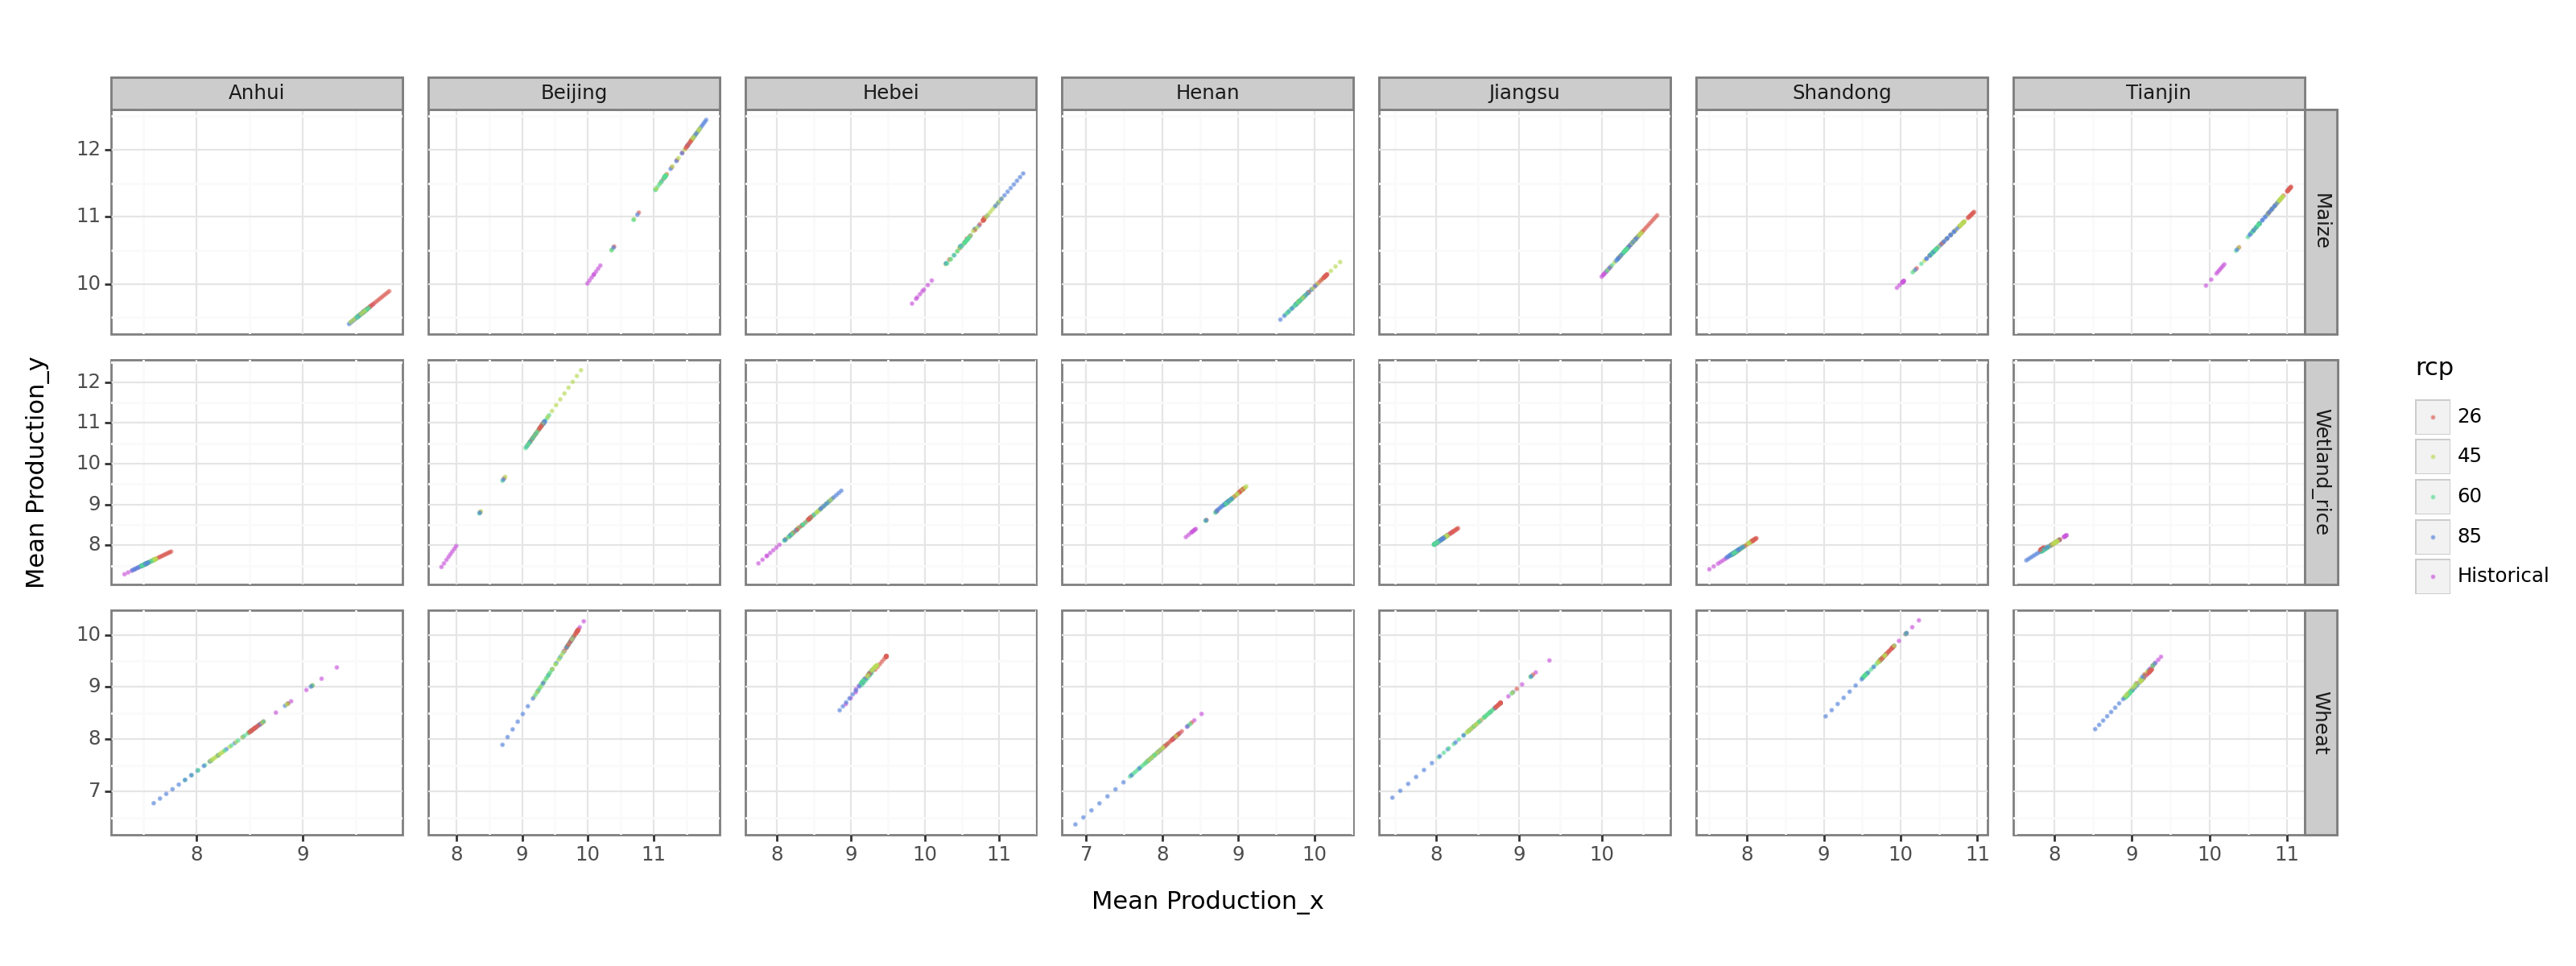

<Figure Size: (1600 x 600)>

In [18]:
# plot the GAEZ/Yearbook data
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

(ggplot() +
 geom_point(df_add_mul_merge, aes('Mean Production_x','Mean Production_y',color='rcp'),alpha=0.5,size=0.2) +
 facet_grid('crop~Province',scales='free') +
 theme_bw()
)

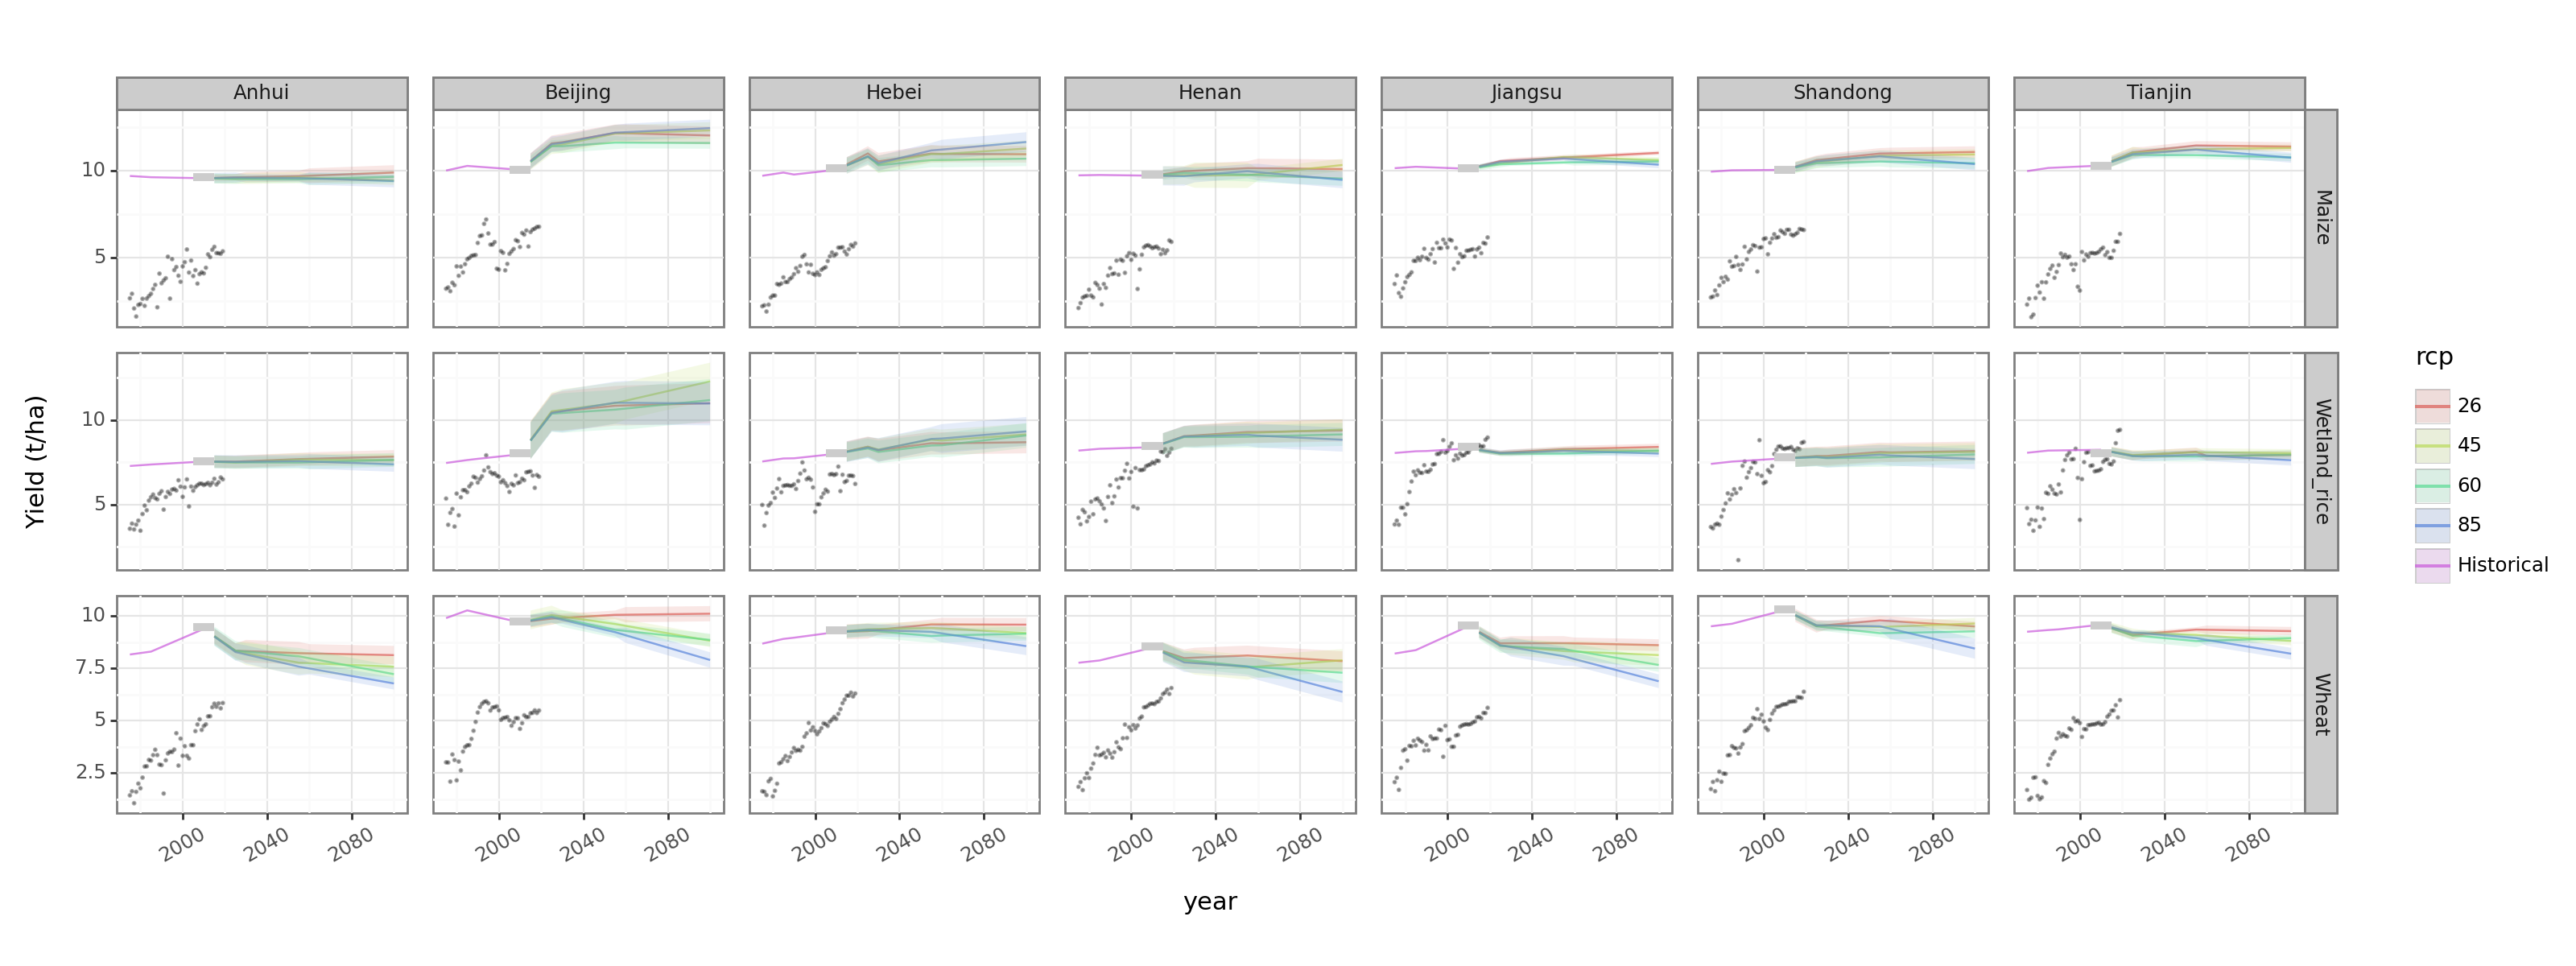

<Figure Size: (1600 x 600)>

In [19]:
# plot the GAEZ/Yearbook data
plotnine.options.figure_size = (16, 6)
plotnine.options.dpi = 100

g = (ggplot() +
 # yearbook records
 geom_point(crop_yield_history_1975_2020, aes('year','Mean Production'),alpha=0.3,size=0.2) +
 # GAEZ_corrected
 geom_line(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes('year','Mean Production',color='rcp'),alpha=0.7) +
 geom_ribbon(GAEZ_attainable_t_ha_forced_with_GYGA_weighted_mean_mul, aes(x='year',ymax='top',ymin='bot',fill='rcp'),alpha=0.15) +
 # GYGA_recored
 geom_line(GYGA_weighted_by_area_ratio, aes('year','Mean Production'),size=2,color='#cccccc') +
 facet_grid('crop~Province',scales='free') +
 theme_bw() + 
 theme(axis_text_x=element_text(rotation=30)) +
 ylab('Yield (t/ha)')
)

g

In [21]:
g.save('../Figs/sup_14_GAEZ_corrected_by_GYGA.svg')

C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 16 x 6 in image.
C:\ProgramData\Miniconda3\envs\gis\lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: ../Figs/sup_14_GAEZ_corrected_by_GYGA.svg
